1. This notebook implements q-learning with softmax action select strategy.
2. Q-function is (state,rewards,action).

In [6]:
import gym
from gym import error, spaces, utils
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from collections import namedtuple, deque
from tqdm import tqdm, trange

In [7]:
from blocks import EnvClass

In [8]:
def playEnv(env,policy):
    
    env.reset()
    s = env.present_state
    done = False
    a = int(policy[s][0])

    cur_reward = 0

    while not done:
        out = env.step(a)
        (s_prime,t),r,done,_ = out
        cur_reward += r
        a = int(policy[int(s_prime)][int(r)])
        
    return cur_reward

In [9]:
def decayParameter(initialValue, finalValue, startStep, maxSteps, decayType):
    arr = [initialValue]
    para = initialValue
    step = 0
    
    if(decayType == 'linear'):
        rate = (initialValue-finalValue)/(maxSteps-startStep)
    else:
        rate = np.power(finalValue/initialValue, 1/(maxSteps-startStep))
    
    while(step < maxSteps):
        step += 1
        
        if(step>startStep):
            if(decayType=='linear'):
                para -= rate
            else:
                para *= rate
        arr.append(para)
        
    return(arr)

In [10]:
def GreedyPolicy(Q):
    
    pi = np.zeros((Q.shape[0],Q.shape[1]))
    
    for s in range(Q.shape[0]):
        
        for r in range(Q.shape[1]):
            
            q = Q[s][r]

            #simple_argmax

            a = np.argmax(q)

            #a = np.random.choice(np.where(q == q.max())[0])

            pi[s][r] = int(a)
        
    return pi

In [24]:
def q_learning(env,tau_s, gamma, alpha, epsilon, noEpisodes):
    curr_q = np.zeros((9,201,8))
    total_rewards = []
    greedy_reward = []
    al,e = alpha[3], epsilon[3]
    
    alpha = decayParameter(*alpha)
    epsilon = decayParameter(*epsilon)
    
    def softmax_actionSelect(curr_state,curr_r,Q,tau):
    
        probs = np.exp(Q[curr_state][curr_r]/tau)/np.sum(np.exp(Q[curr_state][curr_r]/tau))
        if np.isnan(probs).any():
            print(Q[curr_state][curr_r])
        a = np.random.choice(8,p=probs)
        
        return a
    
    def actionSelect(curr_state, curr_r, curr_q, eps):
        if(np.random.uniform(0,1) < eps):
            action = np.random.choice(np.arange(8))
        else:
            if(np.all(curr_q[curr_state][curr_r] == np.zeros(8))):
                action = np.random.choice(np.arange(8))
            else:
                action = np.argmax(curr_q[curr_state][curr_r])
        
        return(action)
    
    for i in trange(noEpisodes):
        env.reset()
        curr_state = env.present_state
        curr_r = 0
        done = False
        
        total_r = 0
        tau = tau_s[e]
        
        while(not done):
#             print(epsilon[int(min(i, e-1))])
            a = softmax_actionSelect(curr_state,curr_r,curr_q,tau)
#             a = actionSelect(curr_state, curr_r, curr_q, epsilon[int(min(i, e-1))])

            (s_new, r, done, _) = env.step(a)
            
            total_r += r
            
            td_target = r
            if(not done):
                td_target += gamma*np.max(curr_q[int(s_new[0])][int(r)])
                
            td_error = td_target - curr_q[curr_state][curr_r][a]
            
#             print(curr_state, a, i)
#             print(alpha[int(min(i, al-1))])
            curr_q[curr_state][curr_r][a] += alpha[int(min(i, al-1))]*td_error
            
            curr_state = s_new[0]
            curr_r = int(r)
        
        total_rewards.append(total_r)
        greedy_reward.append(playEnv(env, GreedyPolicy(curr_q)))
    return curr_q, total_rewards, greedy_reward

## EXPERIMENTATION

In [ ]:
block = 3

In [47]:
gamma = 0.3
alpha = 0.05
epsilon = 1
num_seeds = 3
noEpisodes = 1000

envs = EnvClass()
env = envs.getBlock(block)

Q_s  = np.zeros((num_seeds, 9, 201, 8))
rewards = np.zeros((5, noEpisodes))
greedy_rewards = np.zeros((5, noEpisodes))
tau_i = 1500
tau_f = 10
lin_r = (tau_f - tau_i) / (noEpisodes-1)
exp_r = (tau_f/tau_i)**(1/(noEpisodes-1))
taus = [ tau_i*(exp_r**i) for i in range(noEpisodes)]
# taus = [ tau_i + lin_r*i for i in range(noEpisodes)]

100%|██████████| 1000/1000 [00:24<00:00, 40.56it/s]

24632


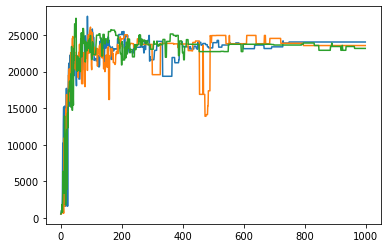

In [48]:
seeds = [4,8,25]
for i in range(num_seeds):
    np.random.seed(seeds[i])
    env.reset()

    Q, reward, greedyReward = q_learning(env, taus,gamma, (alpha, 0.01, 0, noEpisodes, 'exponential'), (epsilon, 0.01, 0, (9*noEpisodes)//10, 'linear'), noEpisodes)

    Q_s[i] = Q
    rewards[i] = reward
    greedy_rewards[i]= greedyReward
    
    plt.plot(greedyReward)

Q = np.mean(Q_s, axis=0)
p = GreedyPolicy(Q)
print(playEnv(env, p))

In [49]:
for q in Q_s:
    print(playEnv(env, GreedyPolicy(q)))

24061
23577
23183


In [53]:
Q = np.mean(Q_s, axis=0)
p = GreedyPolicy(Q)
print(playEnv(env, p))

24632


In [54]:
np.savez('./policies/q_learn/q_learning_B'+str(block)+'_policy_soft.npz', p)
np.savez('./policies/q_learn/q_learning_B'+str(block)+'_reward_soft.npz', rewards)
np.savez('./policies/q_learn/q_learning_B'+str(block)+'_greedy_soft.npz', greedy_rewards)